In [50]:
import pandas as pd
import math

In [51]:
#Split preprocessed data into n partitions
#Reference: https://www.geeksforgeeks.org/how-to-create-multiple-csv-files-from-existing-csv-file-using-pandas/ 
def partition_data(n):
    data = pd.read_csv("../dblp_csv_clean/dblp_preprocessed_final.csv")
    split_file_size = math.ceil(data.shape[0] / n)
    for i in range(n):
        df = data[split_file_size*i:split_file_size*(i+1)]
        df.to_csv(f'../dblp_csv_clean/dblp.split_{i}.csv', index=False)
partition_data(30)

In [52]:
import psycopg2 as ps
import psycopg2.extras as e

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (20, 10)

from itertools import product

In [53]:


# connect to dblp database
con = ps.connect("dbname='akhilajetty' user='postgres' host='localhost' password=''")
cur = con.cursor()


# create view 
query = """create or replace view type_a as 
                   select * from new_view where type=0;
           create or replace view type_b as 
                   select * from new_view where type=1 or type=3;"""
cur.execute(query)
con.commit()


# num_authors group-by decade for the target data type_a
query = "SELECT decade, count(num_authors) FROM type_a GROUP BY decade ;"
cur.execute(query)
target_rows = cur.fetchall()


# num_authors group-by decade for the target data type_b
query = "SELECT decade,count(num_authors) FROM type_b GROUP BY decade;"
cur.execute(query)
ref_rows = cur.fetchall()



In [54]:
def visualize(target_data, ref_data, view_tuple):
    n_groups = len(target_data)
    group_by, measure, function = view_tuple

    means_target = target_data.values()
    means_ref = ref_data.values()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8
    dimension, measure, aggr_func = view_tuple
    print('Dimension - {}, measure - {}, aggregate function - {}'.format(dimension, measure, aggr_func))


    rects1 = plt.bar(index, means_target, bar_width,
                     alpha=opacity,
                     color='y',
                     label='type_a')

    rects2 = plt.bar(index + bar_width, means_ref, bar_width,
                     alpha=opacity,
                     color='c',
                     label='type_b')

    plt.xlabel('{}'.format(group_by))
    plt.ylabel('{}({})'.format(function,measure))
    plt.xticks(index + bar_width, target_data.keys(), rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

Dimension - decade, measure - author, aggregate function - Count


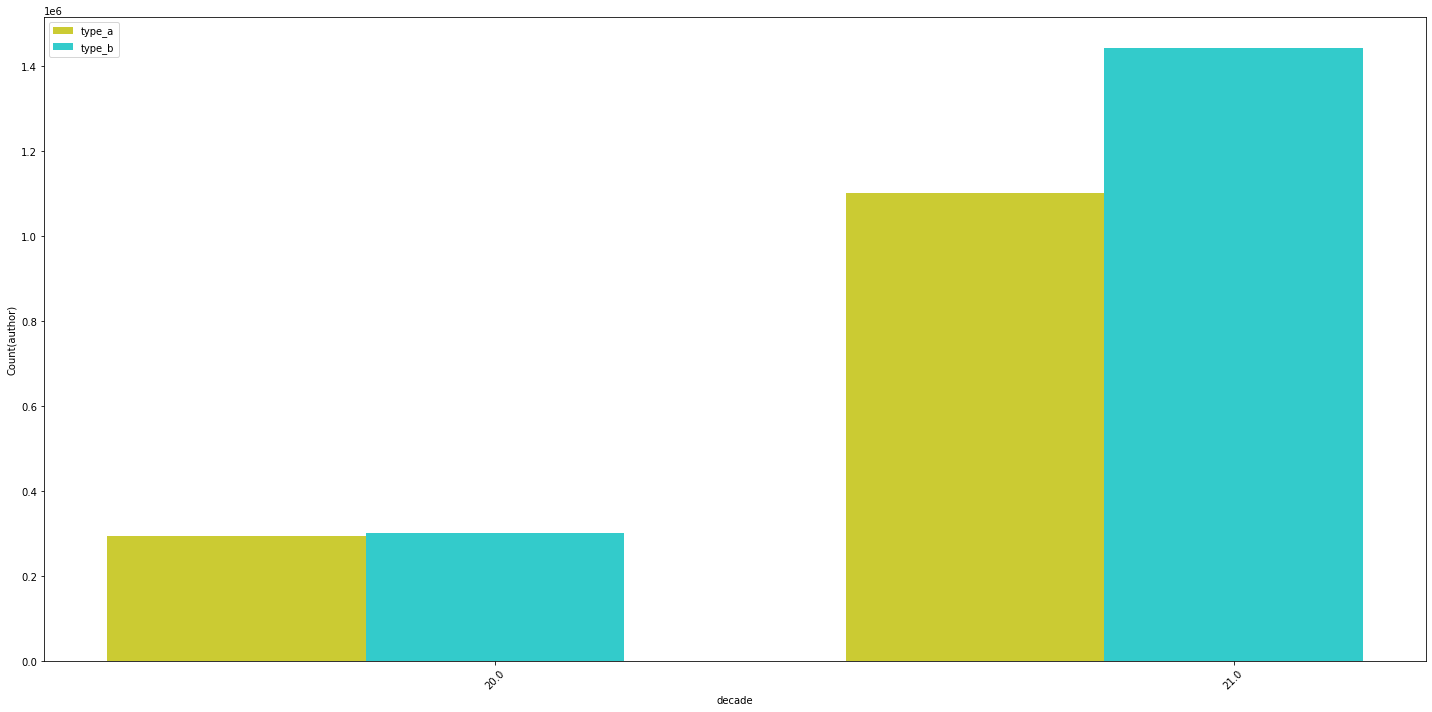

In [55]:
#plotting graph
view_tuple = ('decade', 'author', 'Count')
visualize(dict(target_rows), dict(ref_rows), view_tuple)

In [56]:
%%time

def sharing_based_optimization_query(views, tables):
    
    dimensions = []
    measures = []
    group_by = []
    for i, (f, m, a) in views.items():
        dimensions.append('{}'.format(a))
        #print(dimensions)
        measures.append('{}({}) as v{}'.format(f, m, i))
        #group_by.append('({})'.format(a))
        group_by.append('{}'.format(a))
        #print(group_by)

    select_dimensions = ', '.join(set(dimensions))
    select_measures = ', '.join(measures)
    group_by = ', '.join(set(group_by))

    rows = []
    for table in tables:
        query = """select {}, {} from {} group by grouping sets ({});""".format(select_dimensions, select_measures, table, group_by)
        cur.execute(query)
        rows.append(cur.fetchall())
    #print(cur.description)
    columns = [desc[0] for desc in cur.description]
    
    return rows, columns

CPU times: user 21 µs, sys: 112 µs, total: 133 µs
Wall time: 139 µs


In [57]:
functions = ["sum","min","avg","count"]
attributes = ["years","venue","decade"]
measurements = ["num_authors","page_count"]

total_views = {k: v for k,v in enumerate(list(product(functions, measurements, attributes)))}
print('Total number of visualizations: {}.'.format(len(views)))

Total number of visualizations: 24.


In [58]:
# Apply sharing_based optimization
tables = ['type_a', 'type_b']
rows, cols = sharing_based_optimization_query(total_views, tables)

In [59]:
# KL-Divergence(target, reference)
def kl_divergence(target_val, reference_val):
    probs = []
    target_vals_reshaped = target_val.reshape(-1)
    ref_vals_reshaped = ref_val.reshape(-1)
    #print(ref_vals_reshaped)
    sum_target_vals = np.sum(target_vals_reshaped)
    #print(sum_target_vals)
    sum_ref_vals = np.sum(ref_vals_reshaped)
    #print(sum_ref_values)
    
    # Normalizing values
    if sum_target_vals > 0 and  sum_ref_vals > 0:
        target_vals_normalized = target_vals_reshaped / sum_target_vals
        ref_vals_normalized = ref_vals_reshaped / sum_ref_vals
        for t, r in zip(target_vals_normalized, ref_vals_normalized):
            if r > 0 and t > 0:
                probs.append(t * np.log(r/t))
        #print(-np.sum(probs))
        return -np.sum(probs)
    else:
        return 0.

In [60]:


tgt_df = pd.DataFrame(data[0], columns=cols)
ref_df = pd.DataFrame(data[1], columns=cols)

view_scores = {}
for vid, (f, m, a) in views.items():
    tgt = tgt_df.loc[tgt_df[a].notnull(), [a, 'v{}'.format(vid)]]
    ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(vid)]]
    tmp = tgt.join(ref.set_index(a), on=a, how="inner", lsuffix='_tgt', rsuffix='_ref')
    
    tgt_val = tmp['v{}_tgt'.format(vid)].values
    ref_val = tmp['v{}_ref'.format(vid)].values
    score = kl_divergence(tgt_val, ref_val)
    view_scores[vid] = score

views_ranking = sorted(view_scores.items(), key=lambda x: x[1], reverse=True)



In [61]:
def top_k_views(ranking, k):
    for vid in ranking[:k]:
        f, m, a = views[vid]

        query = "SELECT {}, {}({}) FROM type_a GROUP BY {};".format(a, f, m, a)
        cur.execute(query)
        tgt_rows = cur.fetchall()

        query = "SELECT {}, {}({}) FROM type_b GROUP BY {};".format(a, f, m, a)
        cur.execute(query)
        ref_rows = cur.fetchall()

        tgt_dict = dict(tgt_rows)
        ref_dict = dict(ref_rows)

        for k in tgt_dict.keys():
            if k not in ref_dict:
                ref_dict[k] = 0

        for k in ref_dict.keys():
            if k not in tgt_dict:
                tgt_dict[k] = 0

        visualize(tgt_dict, ref_dict, (a, m, f))

Dimension - decade, measure - num_authors, aggregate function - sum


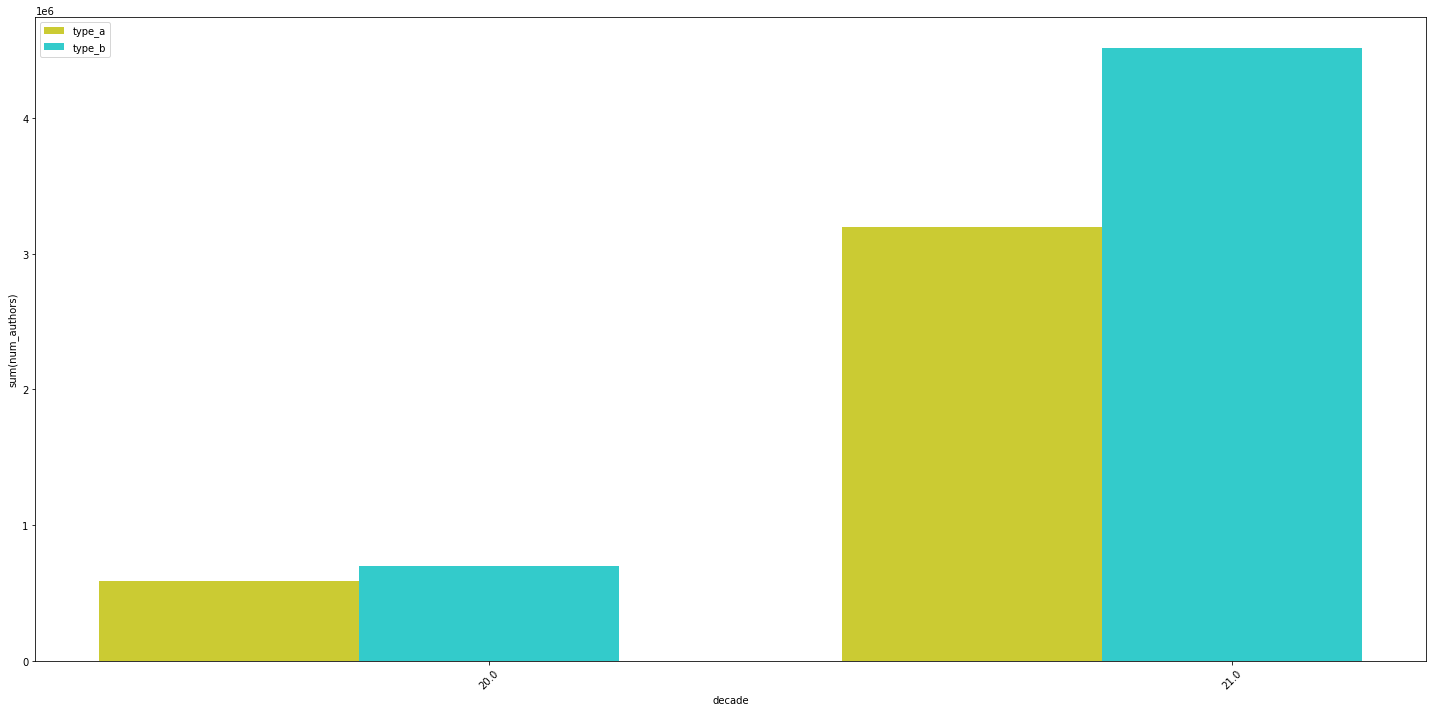

Dimension - decade, measure - num_authors, aggregate function - count


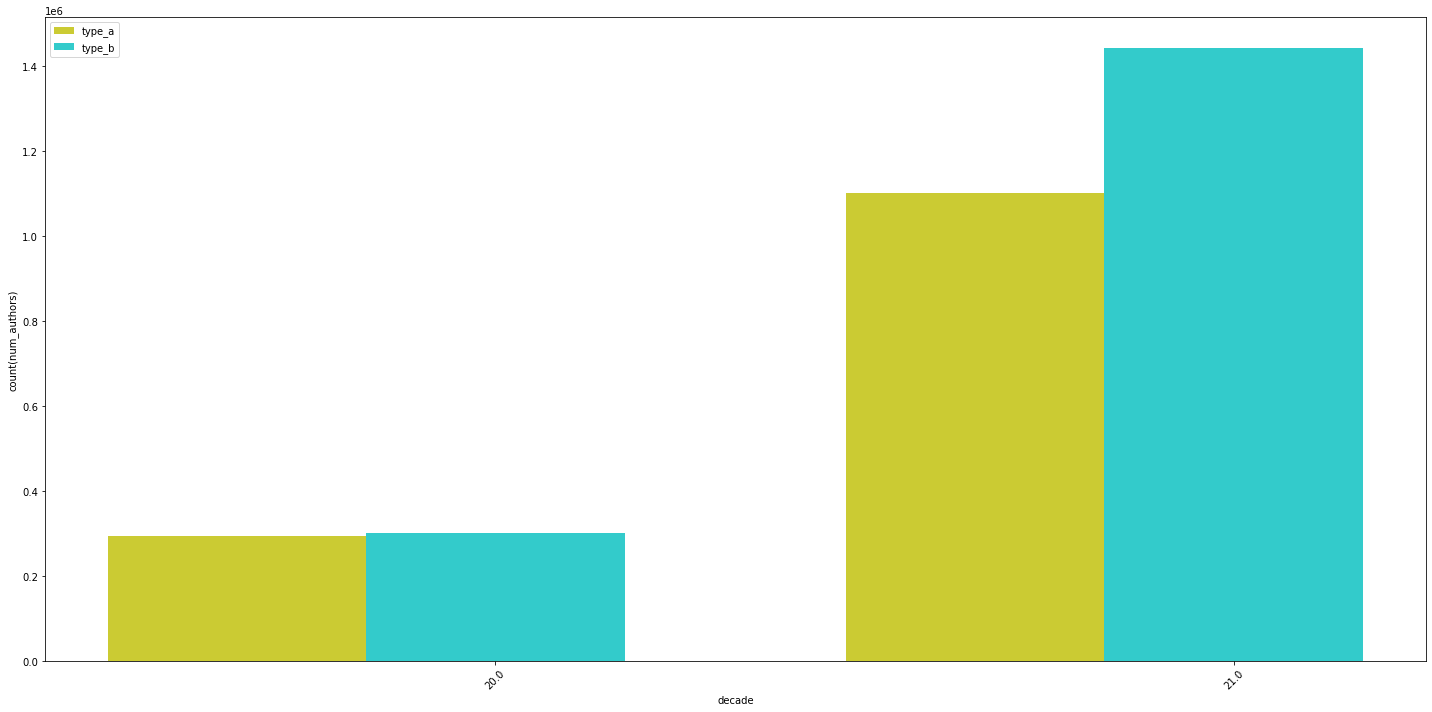

Dimension - decade, measure - page_count, aggregate function - count


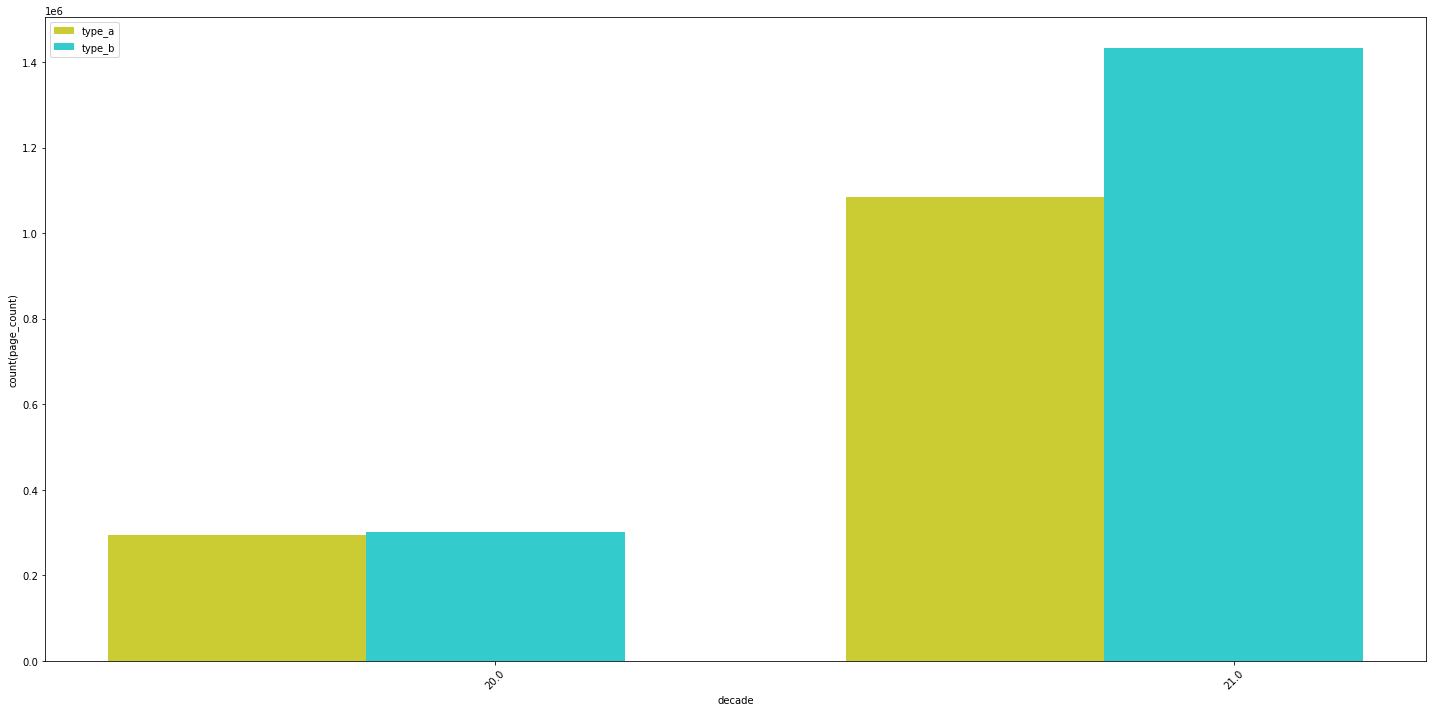

Dimension - years, measure - num_authors, aggregate function - sum


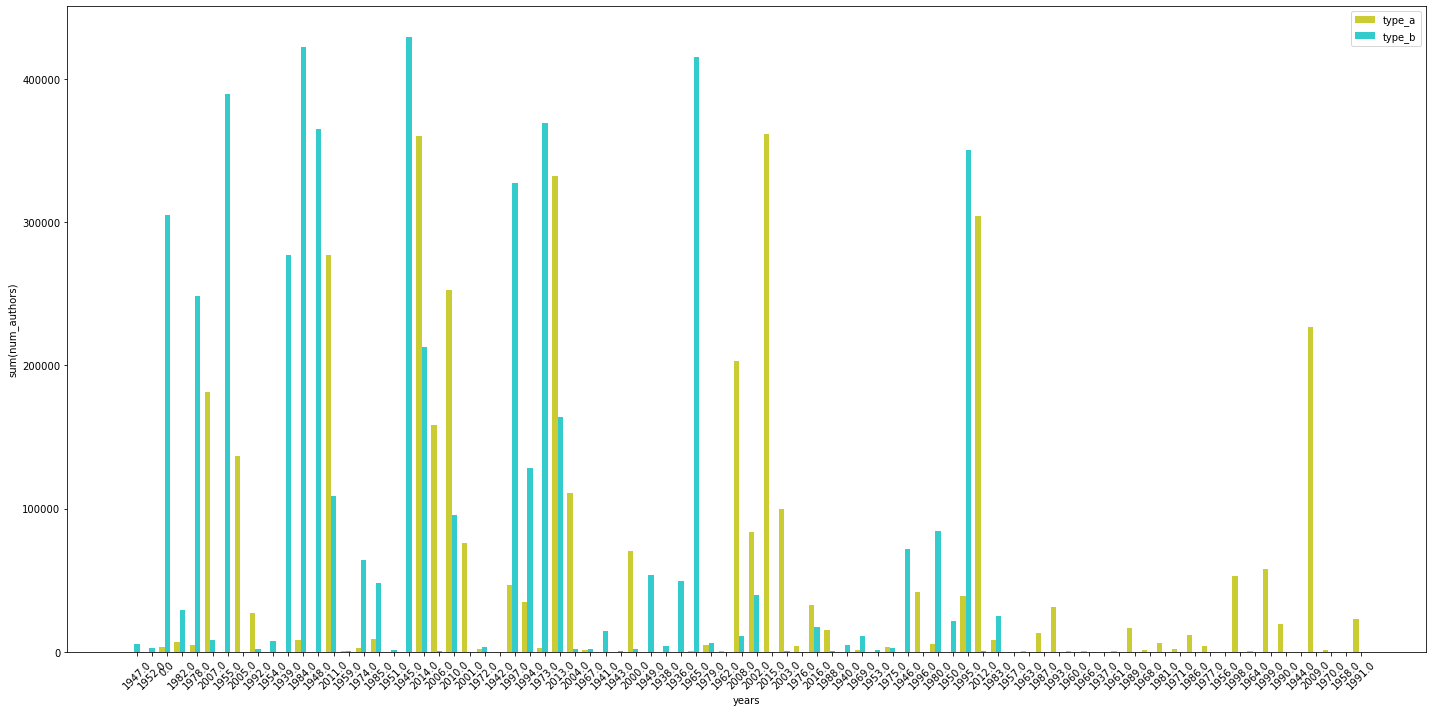

Dimension - years, measure - num_authors, aggregate function - count


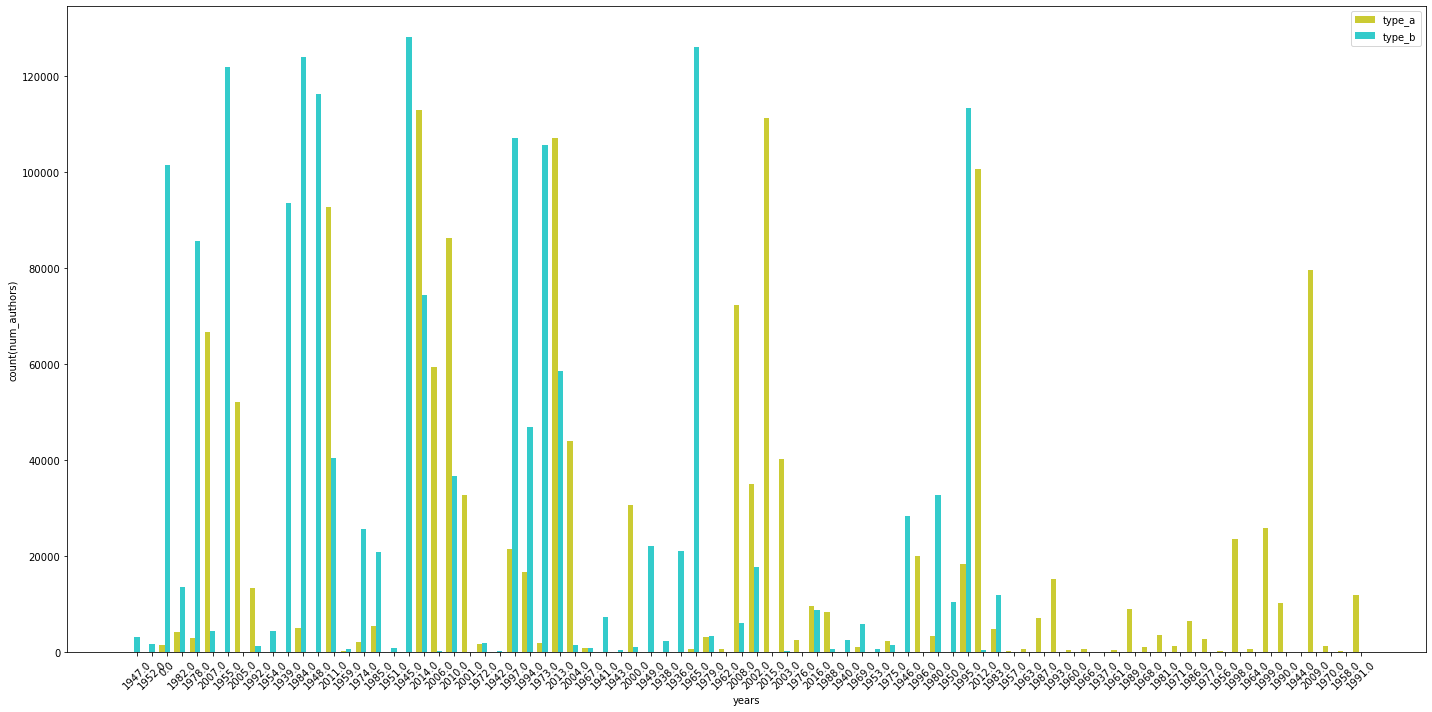

Dimension - years, measure - page_count, aggregate function - count


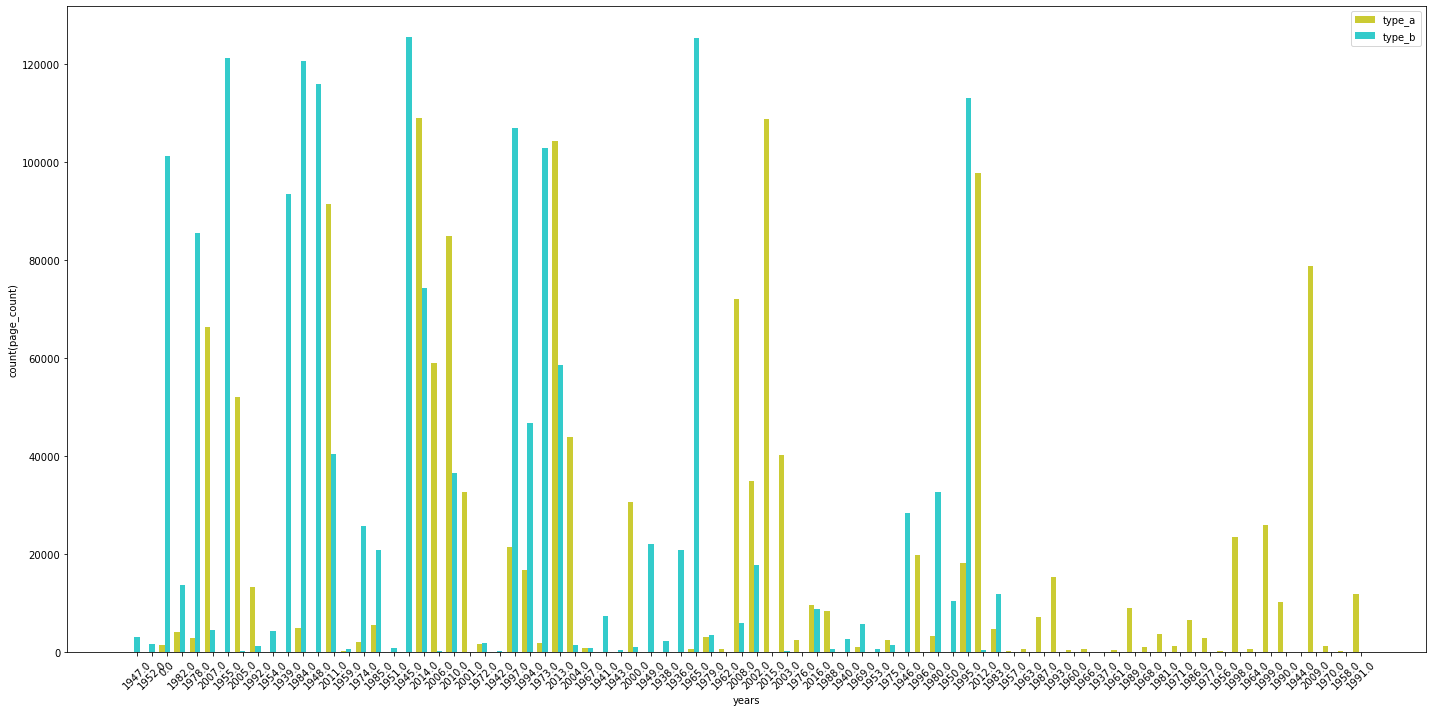

Dimension - years, measure - page_count, aggregate function - sum


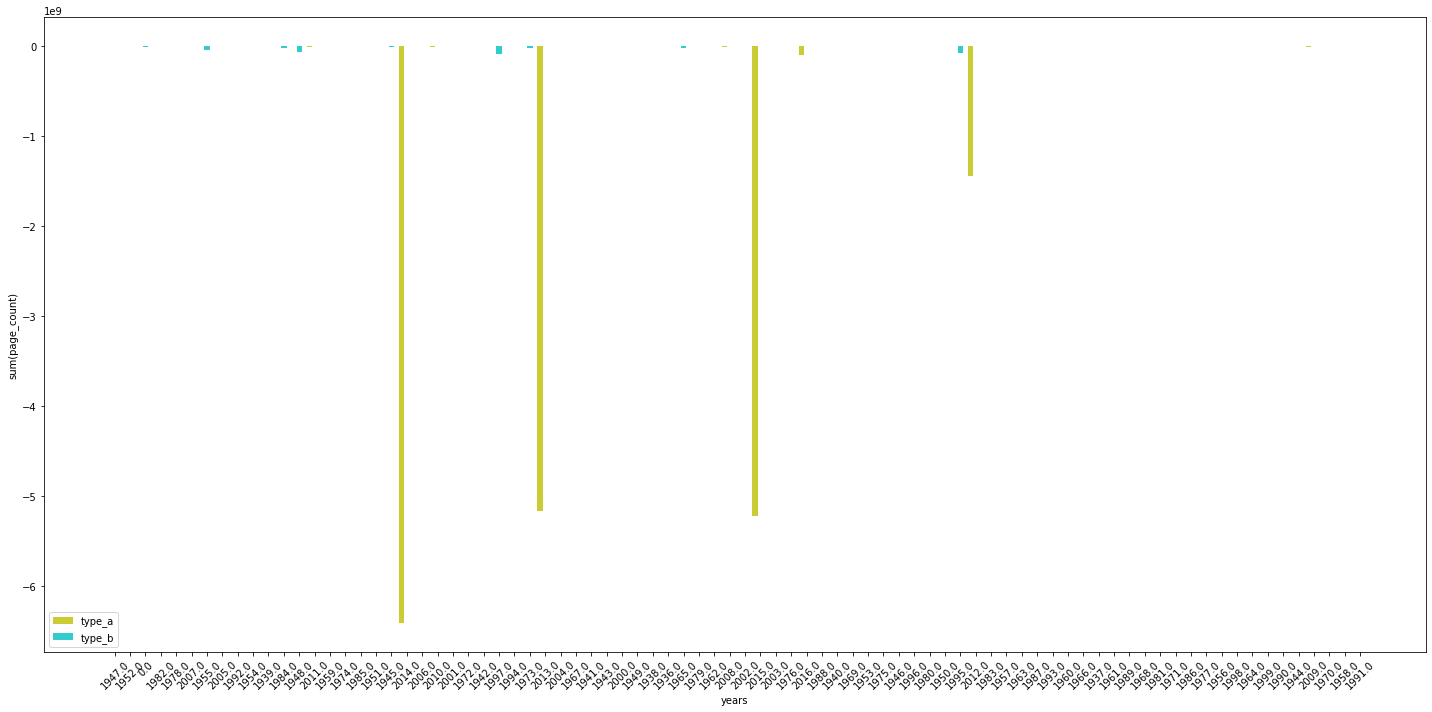

Dimension - years, measure - num_authors, aggregate function - min


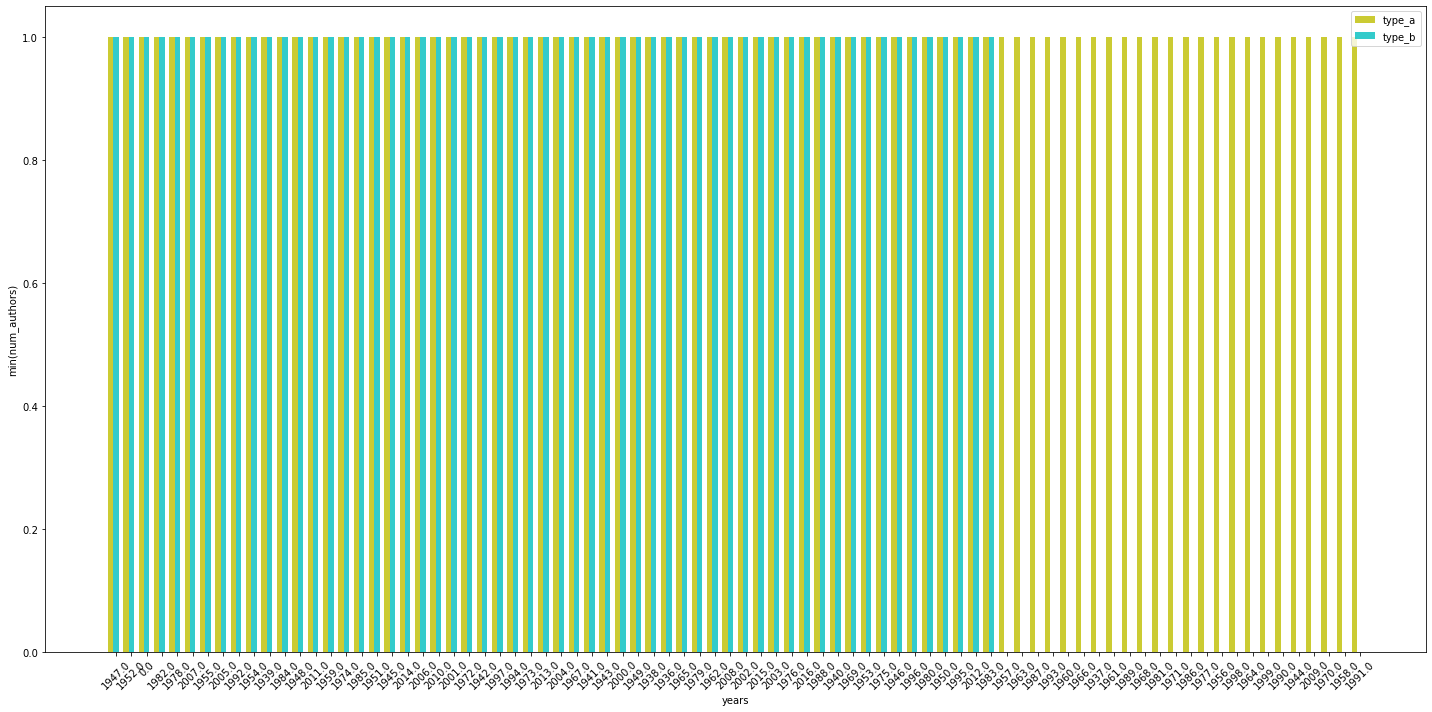

Dimension - years, measure - num_authors, aggregate function - avg


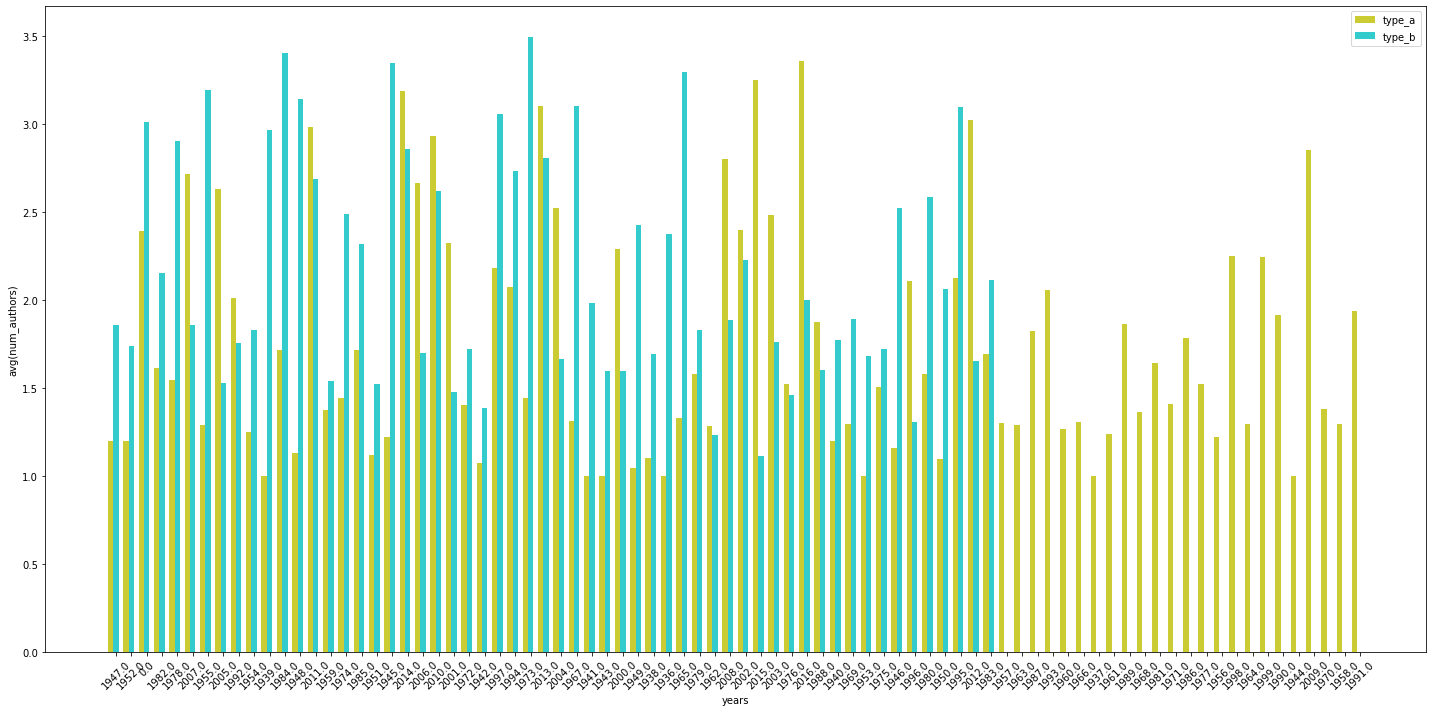

Dimension - decade, measure - num_authors, aggregate function - avg


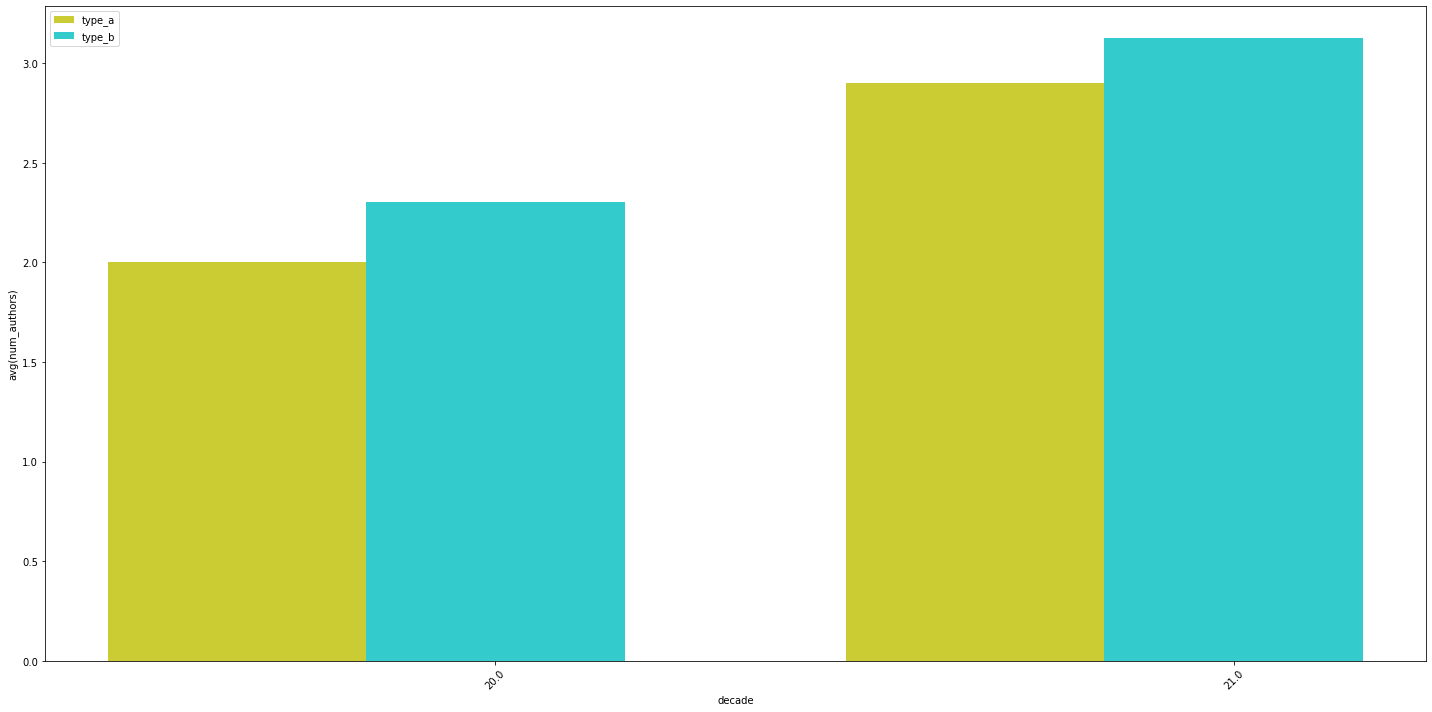

In [62]:
K = 10
top_k_views([r[0] for r in views_ranking], K)

In [9]:
n_phases = 30


for i in range(n_phases):
    query = """create or replace view d_s{}_type_a as 
                   select * from d_split{} where type =0;
           create or replace view d_s{}_type_b as 
                   select * from d_split{} where type=1 or type =3;""".format(i+1,i+1,i+1,i+1)
    
    cur.execute(query)
    con.commit()

# Contribution

Akhila Jetty:
Implemented Sharing based optimization for DBLP
Data preprocessing for Census, DBLP Dataset.
Worked on Target, ref query for DBLP
Sree Nidhi Kanala:
Implemented Pruning: Confidence Interval.
Data preprocessing for Census Dataset
Worked on shared optimization of Census
Nikita Masanagi:
Implemented MAB pruning
Created the Schemas, views and Tables
Consolidated results in report and conclusion
